# Practice: question answering with retrieval

In this homework you will build a retrieval-based question answering system, one component at a time.

_Okay, realistically, there's like, two components, but technically it's one component at a time._


![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)



There are two parts to this type of systems: a retriever and a generator.
- the retriever subsystem searches for similar texts from a given databse, e.g. wikipedia
- the generator uses the texts found by the retriever to generate an answer in natural language

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Part 0: the dataset

Before we train anything, let's take a look at the question answering data that we can use. There are several popular datasets, e.g. TriviaQA for trivia questions or GSM8K for math. Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
%pip install --update transformers accelerate sentencepiece optimum auto-gptq
# ^-- if this fails, remove the specific version and install latest ones: pip install --update transformers accelerate ...
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')


Usage:   
  /usr/local/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/local/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/local/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/local/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/local/bin/python3 -m pip install [options] <archive url/path> ...

no such option: --update


--2024-12-27 17:03:08--  https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3553 (3.5K) [text/plain]
Saving to: ‘data.py’

     0K ...                                                   100% 33.3M=0s

2024-12-27 17:03:08 (33.3 MB/s) - ‘data.py’ saved [3553/3553]

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

TEXT SENTENCES
[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [6]:
from transformers import AutoTokenizer, AutoModel, pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name).to(device)

In [7]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, truncation=True, return_tensors="pt").to(device)
    out = bert(**batch_tensors)
    token_embs = out.last_hidden_state
    cls_embs = out.pooler_output
    del out


mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


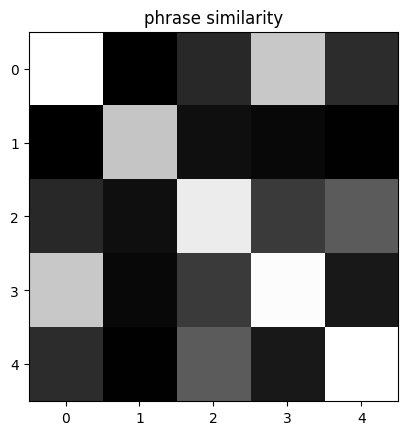

In [8]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Retriever Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors.

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [32]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert, tokenizer=tokenizer):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.hid_size = hid_size
        self.tokenizer = tokenizer

        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        
        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, hid_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid_size, hid_size)
        )

    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]

        Note: you may want to use dropouts.
        if self.training:
          <something>

        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts

        """

        # In fact, please DO use at least 10% dropout!
        with torch.no_grad():
            batch_tensors = self.tokenizer(input_phrases, padding=True, truncation=True, return_tensors="pt").to(device)
            out = self.bert(**batch_tensors)
            token_embs = out.last_hidden_state
            cls_embs = out.pooler_output
            del out


        mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
        naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

        x = self.fc(naive_phrase_embs)

        return x

In [33]:
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)

In [34]:
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

Well done!


### Retriever training: minibatches

Our model learns on triples $(q, a^+, a^-)$:
* q - <b>q</b>uestion
* (a+) - correct <b>a</b>nswer
* (a-) - wrong <b>a</b>nswer

Below you will find a generator that samples such triples from data.

In [35]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [36]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['How old is the building holding the covered market?',
       'What station is going to be available to the Northern Suburbs?',
       'What type of personnel did every camp have?'], dtype=object), 'correct_answers': array(['This covered market traces its origins back to 1610, and the present building dates from 1786.',
       "Little Island Railway Station serves Cork's Eastern Suburbs, while Kilbarry Railway Station is planned to serve the Northern Suburbs.",
       'Each camp had its own religious personnel; standard bearers, priestly officers and their assistants, including a haruspex, and housekeepers of shrines and images.'],
      dtype='<U162'), 'wrong_answers': array(["Other popular tourist attractions include the grounds of University College Cork, through which the River Lee flows, the Women's Gaol at Sundays Well (now a heritage centre) and the English Market.",
       'Stations include Little Island, Mallow, Midleton, Fota and Cobh.',
       'From the 

### Retriever training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_.

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/).

In [37]:
def similarity(a, b):
    """ Dot product as a similarity function """
    return (a * b).sum(axis = 1)

def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    loss = delta - similarity(question_vectors, correct_answer_vectors) + similarity(question_vectors, wrong_answer_vectors)
    return F.relu(loss)

In [38]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

Once loss is working, let's train our model by our usual means.

In [39]:
# we also compute recall: the rate at which a^+ is closer to q than a^-
def get_recall(questions, correct_answers, wrong_answers):

    v_questions = question_vectorizer(questions.tolist())
    v_correct = answer_vectorizer(correct_answers.tolist())
    v_incorrect = answer_vectorizer(wrong_answers.tolist())

    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)

    recall = torch.mean(correct_is_closer.to(torch.float32)).item()

    return recall

In [40]:
# make sure it works
get_recall(**dummy_batch)

0.0

### Training loop (1 point)

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ triplet loss training may be very sensitive to the choice of batch size. Small batch size may decrease model quality because there are less negative to consider.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__.

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [41]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm


# Initialize model, optimizers, anything else you want
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)
model = nn.ModuleList([question_vectorizer, answer_vectorizer])
optimizer = torch.optim.Adam(model.parameters())


ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

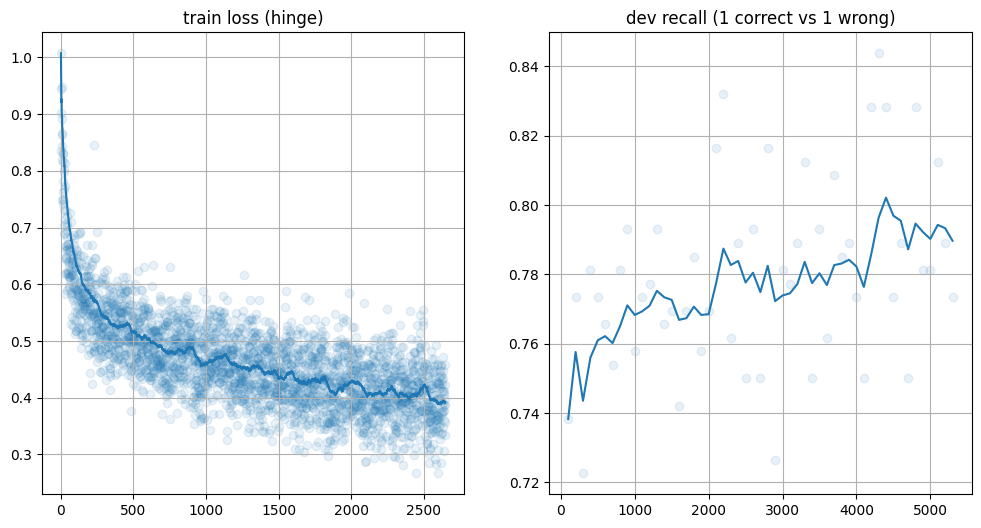

KeyboardInterrupt: 

In [42]:
# infinite training loop. Stop it manually or implement early stopping

for batch in iterate_minibatches(train, batch_size=256, cycle=True):

    # Perform one training step
    question_vectors = batch['questions']
    correct_answer_vectors = batch['correct_answers']
    wrong_answer_vectors = batch['wrong_answers']

    q_vectors = question_vectorizer(list(question_vectors))
    a_plus_vectors = answer_vectorizer(list(correct_answer_vectors))
    a_minus_vectors = answer_vectorizer(list(wrong_answer_vectors))

    loss_t = compute_loss(q_vectors, a_plus_vectors, a_minus_vectors).mean()
    optimizer.zero_grad()
    loss_t.backward()
    optimizer.step()

    loss_history.append(float(loss_t))

    if len(loss_history) % 50 == 0:
        # measure dev recall = P(correct_is_closer_than_wrong | q, a+, a-)
        dev_batch = next(dev_batches)

        recall_t = get_recall(**dev_batch)

        dev_recall_history.append(recall_t)

    if len(loss_history) % 50 == 0:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1), plt.title('train loss (hinge)'), plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))
        plt.subplot(1, 2, 2), plt.title('dev recall (1 correct vs 1 wrong)'), plt.grid()
        dev_time = np.arange(1, len(dev_recall_history) + 1) * 100
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.show()


In [43]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.790625


AssertionError: Please train for at least 85% recall on test set. You may need to change vectorizer model for that.

# Retriever evaluation (2 point)

Let's see how well does our model perform on actual question answering.

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [ ]:
# optional: any additional preparations, e.g. build index
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    <YOUR CODE>
    return <...>


In [ ]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

In [ ]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))

    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT",
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [ ]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

In [ ]:
question = "What is my name?" # your question here!
possible_answers = [
    <...>
    # ^- your options.
]
predicted answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

### Part 2: to prompt a generator (3 points)

You have built a model that can select the most relevant sentence from a text document. However, this is still not the same as question answering - at least not how humans understand it. The full question answering system shoud answer your question in a dialogue - and perhap even let you ask follow-up questions.

In [ ]:
# note: you may want to save pre-trained retriever and restart to free memory
import torch
import transformers

model_name = 'TheBloke/Mistral-7B-Instruct-v0.2-GPTQ'  # feel free to choose any other model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map='auto',
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
)

In [ ]:
pid, question, options, correct_indices, wrong_indices = train.iloc[10]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION What was the first album Beyoncé released as a solo artist? 

TEXT SENTENCES
[ ] Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.
[ ] Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.
[ ] Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.
[v] Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


In [ ]:
question_and_info = """
Question: What was the first album Beyoncé released as a solo artist?

Information: Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
"""  # <-- you should un-hardcode this

input_ids = tokenizer.apply_chat_template([
    dict(role='user', content="""You will be given a question and a piece of information that contains the answer. Please reply with a short informal answer to a question based on the information given.""".strip()),
    dict(role='assistant', content="""Okay, what question would you like me to answer?"""),
    dict(role='user', content=question_and_info.strip())], return_tensors='pt').to(device)
# details: https://huggingface.co/docs/transformers/main/en/chat_templating ; only used for chat/instruct models

output_tokens = model.generate(input_ids, attention_mask=torch.ones_like(input_ids),
                               max_new_tokens=64, do_sample=True, temperature=0.8, top_p=0.9)
print(tokenizer.decode(output_tokens[0, input_ids.shape[1]:]))

The first album Beyoncé released as a solo artist was "Dangerously in Love" in 2003.</s>


### Optional tasks for bonus points

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (2+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Better prompting (2+ pts)

In the previous example, we manually engineer a prompt for an LLM to solve produce an answer. However, by this point you know multiple ways to make LLM do your bidding. In this assignment, you should try at least some of them:
- try few-shot learning with several handcrafted examples (or hand-picked model inputs)
- compare several instruct and/or non-instruct models; for non-instruct models
  - please not that you should not use apply_chat_template for non-instruct models
- provide some means of quality evaluation to compare your approach against the default one

At the minimum, several (10-20) side-by-side examples would do the trick. However, we'd appreciate creative means of evaluation here (crowdsourcing, asking another LM, anything exotic as long as you can explain it).

### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib).
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.
